Pre processing the data. (Skip this code block)

In [35]:
'''
import pandas as pd

# Read and clean data
with open('breast-cancer-data.csv', 'r') as file:
    header = [col.strip().replace("'", "") for col in file.readline().strip().split(',')]
    data = [
        [cell.strip().replace("'", "") for cell in line.strip().split(',')]
        for line in file.readlines()
    ]

# Show sample
print("Header:", header)
print("First 5 rows of data:")
for row in data[:5]:
    print(row)

# Convert to DataFrame
df = pd.DataFrame(data, columns=header)

# Save to cleaned CSV
df.to_csv('breast-cancer-data-cleaned.csv', index=False)
print("Cleaned data saved to 'breast-cancer-data-cleaned.csv'")

'''

'\nimport pandas as pd\n\n# Read and clean data\nwith open(\'breast-cancer-data.csv\', \'r\') as file:\n    header = [col.strip().replace("\'", "") for col in file.readline().strip().split(\',\')]\n    data = [\n        [cell.strip().replace("\'", "") for cell in line.strip().split(\',\')]\n        for line in file.readlines()\n    ]\n\n# Show sample\nprint("Header:", header)\nprint("First 5 rows of data:")\nfor row in data[:5]:\n    print(row)\n\n# Convert to DataFrame\ndf = pd.DataFrame(data, columns=header)\n\n# Save to cleaned CSV\ndf.to_csv(\'breast-cancer-data-cleaned.csv\', index=False)\nprint("Cleaned data saved to \'breast-cancer-data-cleaned.csv\'")\n\n'

In [36]:
# Cell 1: Import libraries
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lime
import lime.lime_tabular
import shap
from sklearn.inspection import permutation_importance

print("All required libraries imported successfully!")

All required libraries imported successfully!


In [37]:
# Cell 2: Load model components function
def load_model_components():
    """Load all saved model components"""
    # Load the full pipeline
    pipeline = joblib.load('breast_cancer_pipeline.joblib')
    
    # Load individual components
    preprocessor = joblib.load('breast_cancer_preprocessor.joblib')
    classifier = joblib.load('breast_cancer_classifier.joblib')
    
    # Load label encoder
    with open('breast_cancer_label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    
    # Load sample data
    with open('breast_cancer_sample_data.pkl', 'rb') as f:
        sample_data = pickle.load(f)
        
    return {
        'pipeline': pipeline,
        'preprocessor': preprocessor,
        'classifier': classifier,
        'label_encoder': label_encoder,
        'sample_data': sample_data
    }

print("Function 'load_model_components' defined. This will load all saved model artifacts.")

Function 'load_model_components' defined. This will load all saved model artifacts.


In [38]:
# Cell 3: Get processed feature names function
def get_processed_feature_names(preprocessor):
    """Get feature names after preprocessing"""
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            if hasattr(transformer, 'get_feature_names_out'):
                feature_names.extend(transformer.get_feature_names_out(cols))
            else:
                feature_names.extend([f"{col}_{i}" for i, col in enumerate(cols)])
    return feature_names

print("Function 'get_processed_feature_names' defined. This helps track feature names through preprocessing steps.")

Function 'get_processed_feature_names' defined. This helps track feature names through preprocessing steps.


In [39]:
# Cell 4: Setup LIME explainer
def setup_lime_explainer(components):
    """Set up LIME explainer with proper categorical handling"""
    X_sample = components['sample_data']['X_train']
    feature_names = components['sample_data']['column_names']
    categorical_cols = components['sample_data']['categorical_cols']
    
    # Create a preprocessed training dataset
    X_sample_processed = components['preprocessor'].transform(X_sample)
    
    # Convert to numpy array if it's not already
    if not isinstance(X_sample_processed, np.ndarray):
        X_sample_processed = X_sample_processed.toarray()
    
    # Get processed feature names
    processed_feature_names = get_processed_feature_names(components['preprocessor'])
    
    # Get categorical feature indices after preprocessing
    categorical_feature_indices = []
    categorical_names = {}
    
    # Create LIME explainer with preprocessed data
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_sample_processed,
        feature_names=processed_feature_names,
        class_names=components['label_encoder'].classes_,
        categorical_features=categorical_feature_indices,
        categorical_names=categorical_names,
        mode='classification',
        discretize_continuous=True,
        kernel_width=3,
        verbose=True
    )
    
    return explainer

print("Function 'setup_lime_explainer' defined. This will initialize the LIME explainer with our model.")

Function 'setup_lime_explainer' defined. This will initialize the LIME explainer with our model.


In [40]:
# Cell 5: Generate LIME explanation
def generate_lime_explanation(explainer, components, instance_idx=0):
    """Generate and display LIME explanation for a specific instance"""
    # Get the instance and preprocess it
    instance = components['sample_data']['X_train'].iloc[instance_idx:instance_idx+1]
    instance_processed = components['preprocessor'].transform(instance)
    
    if not isinstance(instance_processed, np.ndarray):
        instance_processed = instance_processed.toarray()
    
    # Prediction function for LIME
    def predict_fn(X):
        return components['classifier'].predict_proba(X)
    
    # Generate explanation
    explanation = explainer.explain_instance(
        instance_processed[0], 
        predict_fn,
        num_features=10,
        top_labels=1
    )
    
    # Display explanation inline
    fig = explanation.as_pyplot_figure()
    plt.tight_layout()
    plt.show()
    
    return explanation

print("Function 'generate_lime_explanation' defined. This will create and display LIME explanations.")

Function 'generate_lime_explanation' defined. This will create and display LIME explanations.


In [41]:
# Cell 6: Setup SHAP explainer
def setup_shap_explainer(components):
    """Set up SHAP explainer using preprocessed data"""
    # Preprocess the background data
    background = components['preprocessor'].transform(
        components['sample_data']['X_train'].iloc[:50]
    )
    
    # Initialize SHAP explainer
    explainer = shap.Explainer(
        model=components['classifier'].predict_proba,
        masker=background,
        feature_names=get_processed_feature_names(components['preprocessor']),
        output_names=components['label_encoder'].classes_
    )
    
    return explainer

print("Function 'setup_shap_explainer' defined. This will initialize the SHAP explainer.")

Function 'setup_shap_explainer' defined. This will initialize the SHAP explainer.


In [42]:
# Cell 7 (Modified): Generate SHAP explanations with better display
def generate_shap_explanations(explainer, components, num_examples=5):
    """Generate and display SHAP explanations with improved formatting"""
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Get and preprocess examples
    examples = components['preprocessor'].transform(
        components['sample_data']['X_test'].iloc[:num_examples]
    )
    
    # Calculate SHAP values
    shap_values = explainer(examples)
    
    # Plot summary
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:,:,1].values,
        examples,
        feature_names=explainer.feature_names,
        show=False
    )
    plt.tight_layout()
    plt.show()
    
    # Plot individual force plots with better formatting
    for i in range(min(num_examples, 3)):  # Limit to 3 for display
        plt.figure(figsize=(12, 3))  # Wider figure to prevent overlap
        shap.plots.force(
            shap_values[i][:,1],
            matplotlib=True,
            show=False,
            feature_names=explainer.feature_names,
            text_rotation=0  # Keep feature names horizontal
        )
        plt.subplots_adjust(left=0.2, right=0.8)  # Adjust margins
        plt.tight_layout()
        plt.show()
    
    return shap_values

print("Function 'generate_shap_explanations' updated with better display formatting.")

Function 'generate_shap_explanations' updated with better display formatting.


Loading model components...

Generating LIME explanation...
Intercept 0.1931700007022905
Prediction_local [0.72899881]
Right: 0.97


<Figure size 1200x300 with 0 Axes>

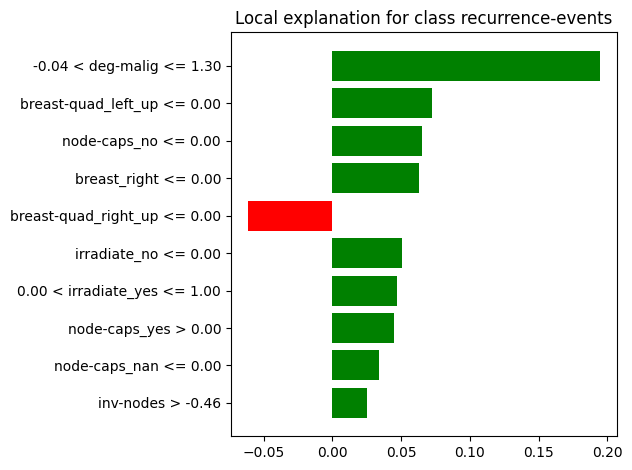


Generating SHAP explanations...


C:\Users\silen\AppData\Local\Temp\ipykernel_9276\3353099392.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


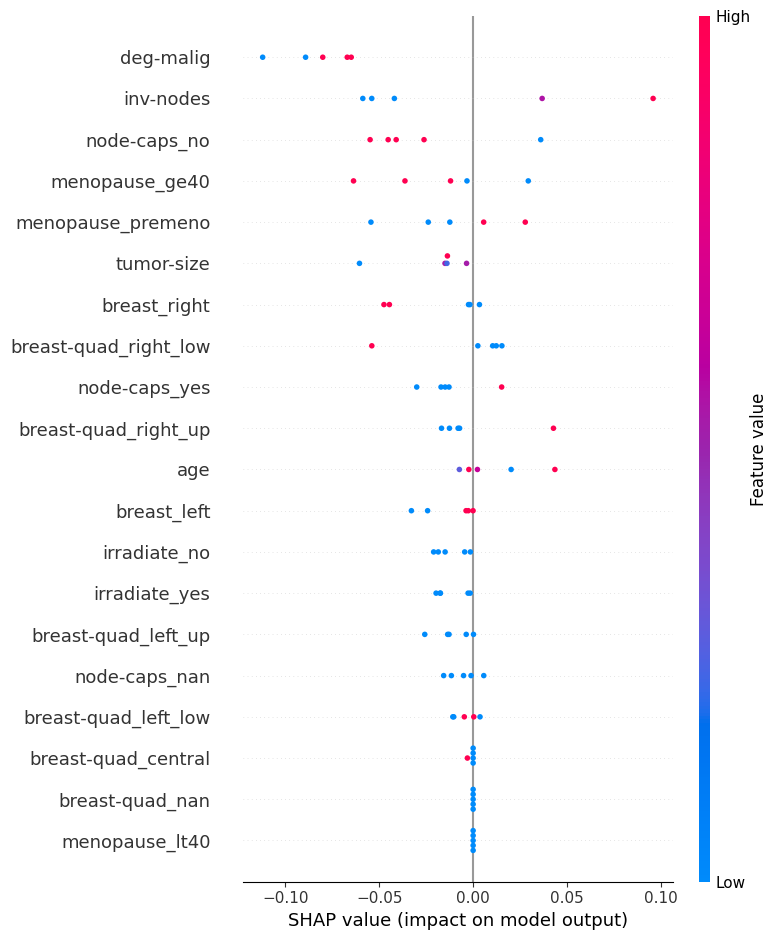

<Figure size 1200x300 with 0 Axes>

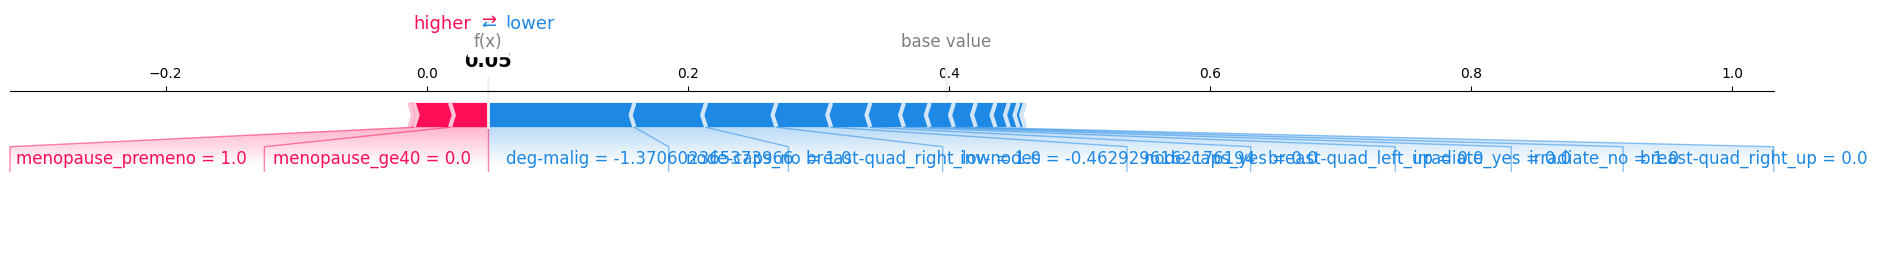

<Figure size 1200x300 with 0 Axes>

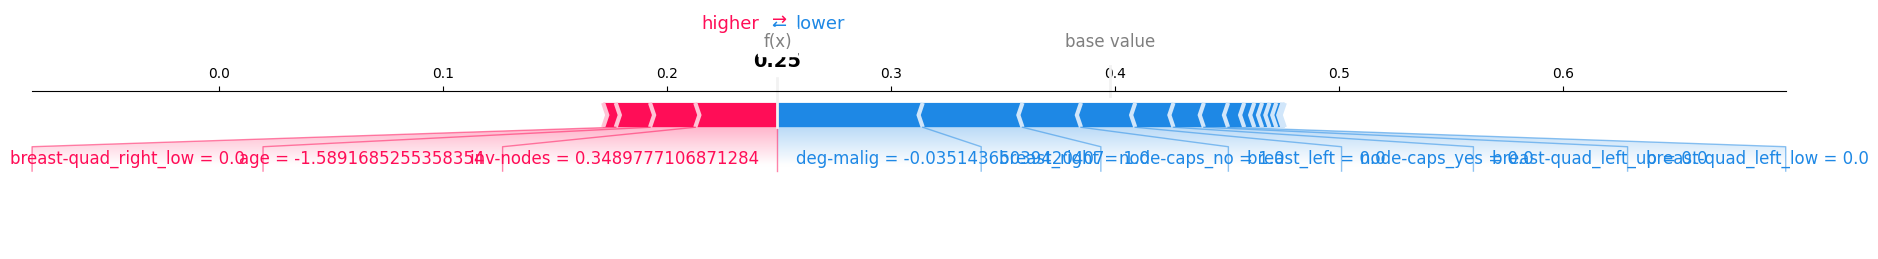

<Figure size 1200x300 with 0 Axes>

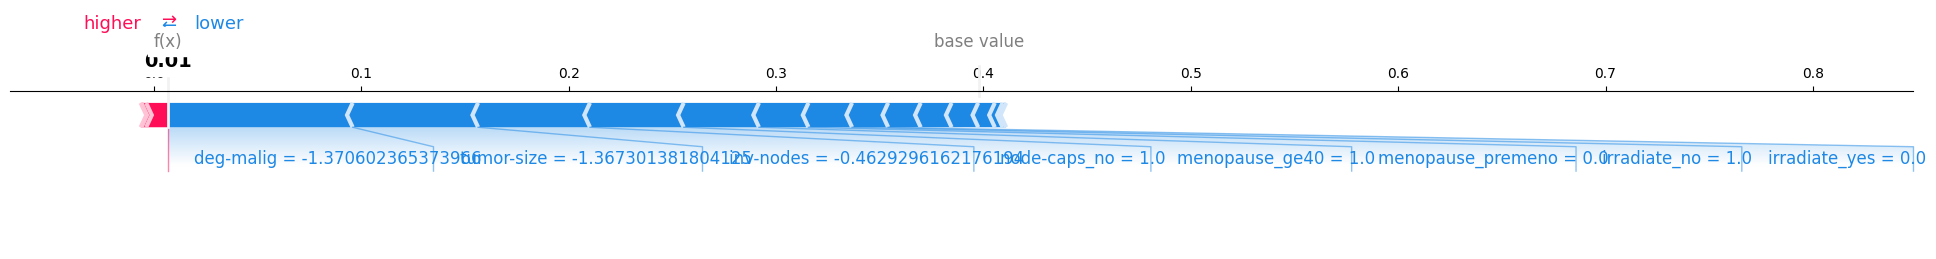


XAI explanations generated successfully!


In [43]:
# Cell 8: Main execution
print("Loading model components...")
components = load_model_components()

print("\nGenerating LIME explanation...")
lime_explainer = setup_lime_explainer(components)
lime_explanation = generate_lime_explanation(lime_explainer, components)

print("\nGenerating SHAP explanations...")
shap_explainer = setup_shap_explainer(components)
shap_values = generate_shap_explanations(shap_explainer, components)

print("\nXAI explanations generated successfully!")